In [1]:
import os
import shutil
import random; random.seed(42)

import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import torch
from torch import nn

import jax
import jax.numpy as jnp
import numpy as np
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt
from functools import partial # reduces arguments to function by making some subset implicit

from jax.experimental import stax
from jax.experimental import optimizers

# visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from moviepy.editor import ImageSequenceClip
from functools import partial
import proglog
from PIL import Image

In [2]:
def lagrangian(q, q_dot, m1, m2, l1, l2, g):
  t1, t2 = q     # theta 1 and theta 2
  w1, w2 = q_dot # omega 1 and omega 2

  # kinetic energy (T)
  T1 = 0.5 * m1 * (l1 * w1)**2
  T2 = 0.5 * m2 * ((l1 * w1)**2 + (l2 * w2)**2 +
                    2 * l1 * l2 * w1 * w2 * jnp.cos(t1 - t2))
  T = T1 + T2
  
  # potential energy (V)
  y1 = -l1 * jnp.cos(t1)
  y2 = y1 - l2 * jnp.cos(t2)
  V = m1 * g * y1 + m2 * g * y2

  return T - V

In [3]:
def f_analytical(state, t=0, m1=1, m2=1, l1=1, l2=1, g=9.8):
  t1, t2, w1, w2 = state
  a1 = (l2 / l1) * (m2 / (m1 + m2)) * jnp.cos(t1 - t2)
  a2 = (l1 / l2) * jnp.cos(t1 - t2)
  f1 = -(l2 / l1) * (m2 / (m1 + m2)) * (w2**2) * jnp.sin(t1 - t2) - \
      (g / l1) * jnp.sin(t1)
  f2 = (l1 / l2) * (w1**2) * jnp.sin(t1 - t2) - (g / l2) * jnp.sin(t2)
  g1 = (f1 - a1 * f2) / (1 - a1 * a2)
  g2 = (f2 - a2 * f1) / (1 - a1 * a2)
  return jnp.stack([w1, w2, g1, g2])

In [4]:
def equation_of_motion(lagrangian, state, t=None):
  q, q_t = jnp.split(state, 2)
  q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t))
          @ (jax.grad(lagrangian, 0)(q, q_t)
             - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
  return jnp.concatenate([q_t, q_tt])

def solve_lagrangian(lagrangian, initial_state, **kwargs):
  # We currently run odeint on CPUs only, because its cost is dominated by
  # control flow, which is slow on GPUs.
  @partial(jax.jit, backend='cpu')
  def f(initial_state):
    return odeint(partial(equation_of_motion, lagrangian),
                  initial_state, **kwargs)
  return f(initial_state)

In [5]:
# Double pendulum dynamics via the rewritten Euler-Lagrange
@partial(jax.jit, backend='cpu')
def solve_autograd(initial_state, times, m1=1, m2=1, l1=1, l2=1, g=9.8):
  L = partial(lagrangian, m1=m1, m2=m2, l1=l1, l2=l2, g=g)
  return solve_lagrangian(L, initial_state, t=times, rtol=1e-10, atol=1e-10)

# Double pendulum dynamics via analytical forces taken from Diego's blog
@partial(jax.jit, backend='cpu')
def solve_analytical(initial_state, times):
  return odeint(f_analytical, initial_state, t=times, rtol=1e-10, atol=1e-10)

def normalize_dp(state):
  # wrap generalized coordinates to [-pi, pi]
  return jnp.concatenate([(state[:2] + np.pi) % (2 * np.pi) - np.pi, state[2:]])

def rk4_step(f, x, t, h):
  # one step of runge-kutta integration
  k1 = h * f(x, t)
  k2 = h * f(x + k1/2, t + h/2)
  k3 = h * f(x + k2/2, t + h/2)
  k4 = h * f(x + k3, t + h)
  return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

In [6]:
class LSTMModel(nn.Module):
    def __init__(self):
        # We want a model of 4 layer LSTM with 32 features output, and a dense layer to form the 4 feature output.
        super(LSTMModel, self).__init__()

        # Defining some parameters
        #self.hidden_size = 32
        #self.n_layers = 4

        #Defining the layers
        # LSTM layer
        self.lstm1 = nn.LSTM(input_size = 4, hidden_size = 32, num_layers = 1, batch_first = True)
        self.lstm2 = nn.LSTM(input_size = 32, hidden_size = 16, num_layers = 1, batch_first = True)
        self.lstm3 = nn.LSTM(input_size = 16, hidden_size = 8, num_layers = 1, batch_first = True)
        # Fully connected layer
        self.fc = nn.Linear(8, 4)
    
    def forward(self, x):
        out1, _= self.lstm1(x) # (h0.detach(), c0.detach())
        out2, _= self.lstm2(out1)
        out3, _= self.lstm3(out2)
        out3 = out3[:, -1, :]
        out = self.fc(out3)
        return out

In [7]:
model = LSTMModel()
model.load_state_dict(torch.load("LSTM_simulate"))
model.eval()

LSTMModel(
  (lstm1): LSTM(4, 32, batch_first=True)
  (lstm2): LSTM(32, 16, batch_first=True)
  (lstm3): LSTM(16, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=4, bias=True)
)

In [13]:
def predict(model, warming_up, gen_len):
    model.eval()
    outputs = []
    inputs = warming_up 
    for i in tqdm(range(gen_len)):
        output = np.array(model(torch.from_numpy(inputs)[None,:,:]).detach())
        outputs.append(output)
        inputs = np.concatenate((inputs[[1,2,3],:],output), axis = 0)
    return np.array(outputs).squeeze()

In [18]:
test_list=[]
x = np.array([3*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32)
t = np.linspace(0, 20, num=305)
x1_analytical = jax.device_get(solve_analytical(x, t))
test_list.append(x_analytical)
test_set=[]

for seq in test_list:
    x = seq[[0,1,2,3],:]
    y = seq[4:]
    test_set.append((x,y))

In [14]:
output = predict(model, test_set[0][0], 301)

100%|████████████████████████████████████████████████████████████████████████████████| 301/301 [00:00<00:00, 880.86it/s]


In [16]:
x1_model = output

In [33]:
seg = x1_analytical[:4]
x1_model = np.insert(x1_model, 0, seg, axis = 0)

In [34]:
def make_plot(i, cart_coords, l1, l2, max_trail=30, trail_segments=20, r = 0.05):
    # Plot and save an image of the double pendulum configuration for time step i.
    plt.cla()

    x1, y1, x2, y2 = cart_coords
    ax.plot([0, x1[i], x2[i]], [0, y1[i], y2[i]], lw=2, c='k') # rods
    c0 = Circle((0, 0), r/2, fc='k', zorder=10) # anchor point
    c1 = Circle((x1[i], y1[i]), r, fc='b', ec='b', zorder=10) # mass 1
    c2 = Circle((x2[i], y2[i]), r, fc='r', ec='r', zorder=10) # mass 2
    ax.add_patch(c0)
    ax.add_patch(c1)
    ax.add_patch(c2)

    # plot the pendulum trail (ns = number of segments)
    s = max_trail // trail_segments
    for j in range(trail_segments):
        imin = i - (trail_segments-j)*s
        if imin < 0: continue
        imax = imin + s + 1
        alpha = (j/trail_segments)**2 # fade the trail into alpha
        ax.plot(x2[imin:imax], y2[imin:imax], c='r', solid_capstyle='butt',
                lw=2, alpha=alpha)

    # Center the image on the fixed anchor point. Make axes equal.
    ax.set_xlim(-l1-l2-r, l1+l2+r)
    ax.set_ylim(-l1-l2-r, l1+l2+r)
    ax.set_aspect('equal', adjustable='box')
    plt.axis('off')
    # plt.savefig('./frames/_img{:04d}.png'.format(i//di), dpi=72)

def radial2cartesian(t1, t2, l1, l2):
  # Convert from radial to Cartesian coordinates.
  x1 = l1 * np.sin(t1)
  y1 = -l1 * np.cos(t1)
  x2 = x1 + l2 * np.sin(t2)
  y2 = y1 - l2 * np.cos(t2)
  return x1, y1, x2, y2

def fig2image(fig):
  fig.canvas.draw()
  data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
  image = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
  return image

In [35]:
L1, L2 = 1, 1
theta1mod, theta2mod = x1_model[:, 0], x1_model[:, 1]
cart_coords_mod = radial2cartesian(theta1mod, theta2mod, L1, L2)

L1, L2 = 1, 1
theta1ana, theta2ana = x1_analytical[:, 0], x1_analytical[:, 1]
cart_coords_ana = radial2cartesian(theta1ana, theta2ana, L1, L2)

In [40]:
def cart_coords_over_time(cart_coords):
    x1, y1, x2, y2 = cart_coords
    
    length = len(x2)
    t = np.arange(length)
    
    plt.title("LSTM Double Pendulum " + f"Timeseries - {length - 5} timesteps")

    plt.plot(x2, y2, marker='.', color="lightgray", zorder=0)
    plt.scatter(x2, y2, marker='o', c=t[:length], cmap="viridis", s=10, zorder=1)

    plt.xlabel("$x$")
    plt.ylabel("$y$")

    cbar = plt.colorbar()
    cbar.ax.set_ylabel('$t$', rotation=270)

    #plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()

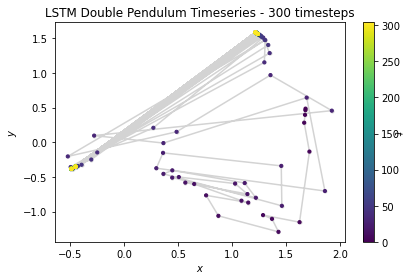

In [41]:
cart_coords_over_time(cart_coords_mod)

0/300
1/300 2/300 3/300 4/300 5/300 6/300 7/300 8/300 9/300 10/300 11/300 12/300 13/300 14/300 15/300 16/300 17/300 18/300 19/300 20/300
21/300 22/300 23/300 24/300 25/300 26/300 27/300 28/300 29/300 30/300 31/300 32/300 33/300 34/300 35/300 36/300 37/300 38/300 39/300 40/300
41/300 42/300 43/300 44/300 45/300 46/300 47/300 48/300 49/300 50/300 51/300 52/300 53/300 54/300 55/300 56/300 57/300 58/300 59/300 60/300
61/300 62/300 63/300 64/300 65/300 66/300 67/300 68/300 69/300 70/300 71/300 72/300 73/300 74/300 75/300 76/300 77/300 78/300 79/300 80/300
81/300 82/300 83/300 84/300 85/300 86/300 87/300 88/300 89/300 90/300 91/300 92/300 93/300 94/300 95/300 96/300 97/300 98/300 99/300 100/300
101/300 102/300 103/300 104/300 105/300 106/300 107/300 108/300 109/300 110/300 111/300 112/300 113/300 114/300 115/300 116/300 117/300 118/300 119/300 120/300
121/300 122/300 123/300 124/300 125/300 126/300 127/300 128/300 129/300 130/300 131/300 132/300 133/300 134/300 135/300 136/300 137/300 138/30

Moviepy - Done !
Moviepy - video ready DoublePendulumLSTMMotion.mp4


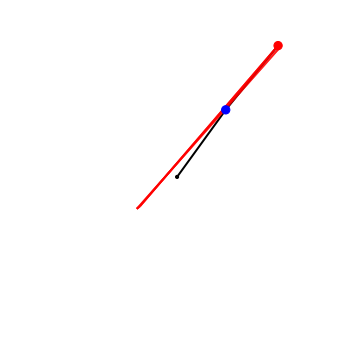

In [42]:
fig = plt.figure(figsize=(8.3333, 6.25), dpi=72)
ax = fig.add_subplot(111)

import warnings
warnings.filterwarnings("ignore")

images = []
di = 1
N = 300
for i in range(0, N, di):
  print("{}/{}".format(i // di, N // di), end='\n' if i//di%20==0 else ' ')
  make_plot(i, cart_coords_mod, 1, 1)
  images.append( fig2image(fig) )

analytical_clip = ImageSequenceClip(images, fps=25)
analytical_clip.write_videofile("DoublePendulumLSTMMotion.mp4")

In [43]:
def cart_error_over_time(cart_coords_model, cart_coords_ana):
    x11, y11, x21, y21 = cart_coords_ana
    x12, y12, x22, y22 = cart_coords_model
    
    distance_1 = np.sqrt((np.square(np.absolute(x11 - x12)) + np.square(np.absolute(y11 - y12))))
    distance_2 = np.sqrt((np.square(np.absolute(x21 - x22)) + np.square(np.absolute(y21 - y22))))
    
    index = np.arange(np.size(distance_1))
    
    plt.plot(index, distance_1, label='first pendulum arm')
    plt.plot(index, distance_2, label='second pendulum arm')
    plt.legend(loc="upper right")
    
    plt.title('Error Over Time by Distance')
    plt.xlabel('Timestep')
    plt.ylabel('Distance')

    plt.show()

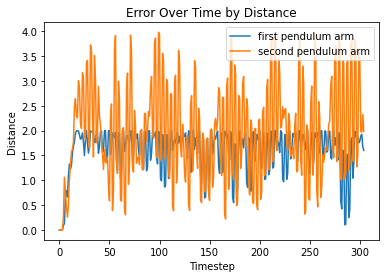

In [44]:
cart_error_over_time(cart_coords_mod, cart_coords_ana)

In [45]:
def theta_error_over_time(theta1_model, theta2_model, theta1_ana, theta2_ana):
    distance_1 = theta1_model - theta1_ana
    distance_2 = theta2_model - theta2_ana
    
    index = np.arange(np.size(distance_1))
    
    plt.plot(index, distance_1, label='first pendulum arm')
    plt.plot(index, distance_2, label='second pendulum arm')
    plt.legend(loc="upper left")
    
    plt.title('Error Over Time by Angle')
    plt.xlabel('Timestep')
    plt.ylabel('Angle (radians)')

    plt.show()

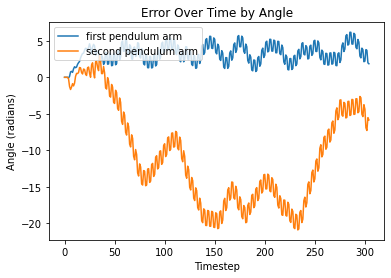

In [46]:
theta_error_over_time(theta1mod, theta2mod, theta1ana, theta2ana)